In [22]:
PROCESSES_COUNT = 20

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools, model_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm
from uncertainties import ufloat

results = []

folder_filename = lambda run_id: f"../results/RUNDATA_R26_{run_id}"

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    tallydf=sp.tallies[2].get_pandas_dataframe() # Tally 2 is in the moderator
    tallydf_flux=tallydf[tallydf['score']=='flux']
    energy=(tallydf_flux['energy low [eV]']+tallydf_flux['energy high [eV]'])/2

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path,
        "energy": energy,
        "flux": tallydf_flux["mean"],
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 2 result folders
Loading data with 20 processes...


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


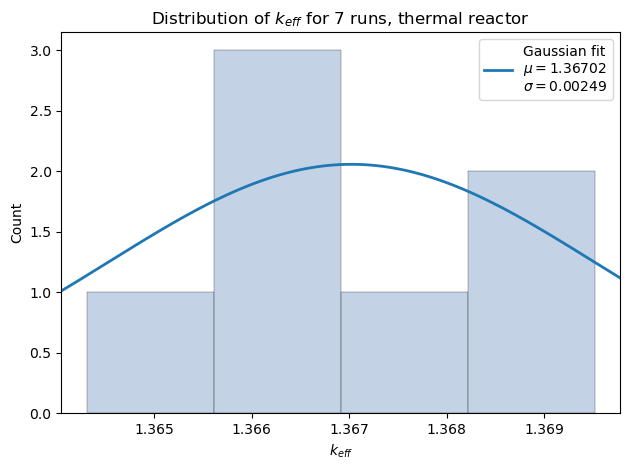

In [7]:
importlib.reload(plot_tools)
importlib.reload(model_tools)

# PLOT SETTINGS:
REACTOR_MODEL = model_tools.THERMAL_REACTOR
USE_SAMPLED_DATA = True

SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

folder_name = f"plots-{REACTOR_MODEL}-{SAMPLED_STRING}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{REACTOR_MODEL}-{SAMPLED_STRING}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["reactor_model"] == REACTOR_MODEL]
df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

plt.figure()
fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs, {REACTOR_MODEL.lower()} reactor", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

# plt.figure()
# fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
#                                         fit_gaussian=True, decimals=0,
#                                         title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
#                                         filename=get_filename("heatmap", "distribution-rho"))

In [4]:
importlib.reload(plot_tools)
importlib.reload(data_tools)
importlib.reload(model_tools)
import pickle

# Create a dataframe from the results
df = pd.DataFrame(results)

# TMC analysis
for REACTOR_MODEL in [model_tools.SEMIEPITHERMAL_REACTOR]:
    tmc_v1_res = data_tools.perform_TMC_v1(df, REACTOR_MODEL, print_output=True)

    # Save dict to pickle file
    with open(f"R26-tmc_v1_res-{REACTOR_MODEL}.pkl", "wb") as f:
        pickle.dump(tmc_v1_res, f)

    print("")


TMC analysis v1
SEMIEPITHERMAL
Sampling all MTs
Based on 500 runs
 -- k_eff --
k_eff: 		1.277
σ_obs: 		1.70e-03
σ_stat_mean: 	3.15e-04
σ_ND: 		1.67e-03
R_obs: 		133.3 pcm
R_stat_mean: 	24.7 pcm
R_ND: 		131.0 pcm
 -- ρ --
ρ: 		21672.9 pcm
ρ-std: 		102.6 pcm



In [15]:
# TMC analysis 15 april 2023, to get table for paper

importlib.reload(plot_tools)
importlib.reload(data_tools)
importlib.reload(model_tools)
import pickle

# Create a dataframe from the results
df = pd.DataFrame(results)

table_results = []

# TMC analysis
for REACTOR_MODEL in [model_tools.THERMAL_REACTOR, model_tools.SEMIEPITHERMAL_REACTOR, model_tools.EPITHERMAL_REACTOR]:
    tmc_v1_res = data_tools.perform_TMC_v1(df, REACTOR_MODEL, print_output=False)

    u_k = tmc_v1_res["u_k"]
    u_rho = tmc_v1_res["u_rho"]

    # print(tmc_v1_res)
    table_results.append({
        "Reactor model": REACTOR_MODEL.capitalize(),
        "$k_{eff}$": float(f"{u_k.nominal_value:.4f}"),
        "$\sigma_{k_{eff}}$ [pcm]": float(f"{u_k.std_dev*1e5:.1f}"),
        "$\sigma_{k_{eff}}/k_{eff}$ [%]": float(f"{u_k.std_dev/u_k.nominal_value*100:.2f}"),
        r"$\rho$": float(f"{u_rho.nominal_value:.4f}"),
        r"$\sigma_{\rho}$ [pcm]": float(f"{u_rho.std_dev*1e5:.1f}"),
    })

    print(tmc_v1_res)

df_for_table = pd.DataFrame(table_results)
table = df_for_table.to_latex(index=False, escape=False)
print(table)

{'sigma_obs': 0.0012118790999203646, 'sigma2_obs': 1.468650952823793e-06, 'sigma_stat_mean': 0.00031530070863785187, 'sigma2_stat_mean': 9.941453686753157e-08, 'sigma_ND': 0.0011701437586708145, 'sigma2_ND': 1.3692364159562615e-06, 'k_eff_mean': 1.3669562764165861, 'R_obs': 0.0008865529357656199, 'R_stat_mean': 0.0002306589567476133, 'R_ND': 0.0008560213511278454, 'u_k': 1.3669562764165861+/-0.0011701437586708145, 'u_rho': 0.26844770586118916+/-0.0006262243832493799, 'N_ITERATIONS': 500, 'reactor_model': 'THERMAL'}
{'sigma_obs': 0.0017015978399375583, 'sigma2_obs': 2.8954352088801643e-06, 'sigma_stat_mean': 0.00031507044945824013, 'sigma2_stat_mean': 9.926938812181745e-08, 'sigma_ND': 0.001672173980409439, 'sigma2_ND': 2.796165820758347e-06, 'k_eff_mean': 1.2766968225230233, 'R_obs': 0.001332812778976641, 'R_stat_mean': 0.00024678564550320895, 'R_ND': 0.001309765913809411, 'u_k': 1.2766968225230233+/-0.001672173980409439, 'u_rho': 0.21672868424330516+/-0.0010259020706427672, 'N_ITERATI

/tmp/ipykernel_42044/3393397972.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df_for_table.to_latex(index=False, escape=False)


In [16]:
importlib.reload(plot_tools)
importlib.reload(data_tools)
import pickle

# TMC analysis v1 and v3 to see OpenMC discrepancies

# Create a dataframe from the results
df = pd.DataFrame(results)

for REACTOR_MODEL in [model_tools.THERMAL_REACTOR, model_tools.SEMIEPITHERMAL_REACTOR, model_tools.EPITHERMAL_REACTOR]:
    tmc_v1_res = data_tools.perform_TMC_v1(df, REACTOR_MODEL, print_output=False)
    tmc_v3_res = data_tools.perform_TMC_v3(df, REACTOR_MODEL, print_output=False)

    print("")


No data for THERMAL (not sampled)

No data for SEMIEPITHERMAL (not sampled)

No data for EPITHERMAL (not sampled)



In [44]:
# May 14 2023 - Plot flux with its uncertainty
df = pd.DataFrame(columns=["energy", "flux", "use_thermal_scattering"])
for result in results:
    energy = result["energy"]
    flux = result["flux"]
    use_thermal_scattering = result["use_thermal_scattering"]
    
    plt.loglog(energy, flux, label=f"use_thermal_scattering={use_thermal_scattering}")

    if use_thermal_scattering == True:
        flux_themal_scattering = flux
    else:
        flux_no_thermal_scattering = flux


# sns.lineplot(data=df, x="energy", y="flux", hue="use_thermal_scattering")
ax = plt.gca()
plt.xlim(1e-2, 1e6)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Energy [eV]")
plt.ylabel('Group flux per source particle [particle-cm/source]')

plt.savefig(f"TSL_flux_thermal_R26.pdf")



# Plot difference (bot absolute and relative) between flux with and without thermal scattering
plt.figure()
plt.loglog(energy, flux_themal_scattering - flux_no_thermal_scattering, label="Absolute difference (TSL - no TSL)")
plt.xlim(1e-2, 1e6)
plt.legend()
plt.xlabel("Energy [eV]")
plt.ylabel('Absolute group flux difference [particle-cm/source]')
plt.savefig(f"TSL_flux_difference_absolute.pdf")

plt.figure()
plt.semilogx(energy, 100*np.abs((flux_themal_scattering - flux_no_thermal_scattering) / flux_themal_scattering), label="Norm of Relative difference (TSL - no TSL)/TSL")
plt.xlim(1e-2, 1e6)
plt.ylim(0, 15)
plt.legend()
plt.xlabel("Energy [eV]")
plt.ylabel('Relative group flux difference [%]')
plt.savefig(f"TSL_flux_difference_relative.pdf")

plt.close('all')
